In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,classification_report
import matplotlib . pyplot as plt
import seaborn as sns

def reLU(x : np.ndarray)-> np.ndarray : 
    """ReLU activation : max(0,x)
    Parameters :
        x (np.ndarray) : Tableau NumPy d'entree.
    Returns :
        np.ndarray: Tableau Numpy resultant.
    """
    assert isinstance(x, np.ndarray) , "Input must be a NumPy ndarray"
    assert x.size > 0, "Input array cannot be empy"
    result = np.maximum( 0 , x)
    assert isinstance(result, np.ndarray), "Output must be a Numpy ndarray"
    assert result.shape == x.shape, "Output shape must match input shape"
    assert np.all((result >= 0) ), "ReLU output must be non-negative "
    return result
def relu_derivative(x : np.ndarray)-> np.ndarray : 
    """Derivative of ReLU : if x > 0, else 0
    Parameters :
        x (np.ndarray) : Tableau NumPy d'entree.
    Returns :
        np.ndarray: Tableau Numpy resultant.
    """
    assert isinstance(x, np.ndarray) , "Input to ReLU derivative must be a NumPy array"
    assert x.size > 0, "Input array cannot be empy"
    result = (x > 0)
    assert isinstance(result, np.ndarray), "Output must be a Numpy ndarray"
    assert result.shape == x.shape, "Output shape must match input shape"
    assert np.all((result == 0) | (result <= 1) ), "ReLU derivative Output must be 0 or 1 "
    return result


def sigmoid ( x ): 
    """
    Segmoid activation : 1 / (1 + exp(-x))
    Parameters :
        x (np.ndarray) : Tableau NumPy d'entree.
    Returns :
        np.ndarray: Tableau Numpy resultant.
    """
    assert isinstance(x, np.ndarray) , "Input to sigmoi must be a NumPy ndarray"
    assert x.size > 0, "Input array cannot be empy"
    result = 1 / (1 + np.exp(-x))
    assert isinstance(result, np.ndarray), "Output must be a Numpy ndarray"
    assert result.shape == x.shape, "Output shape must match input shape"
    assert np.all((result >= 0) & (result <= 1) ), "Segmoid Output must be between 0 and 1 "
    return result

def sigmoid_derivative ( x ): 
    """
    Derivative of segmoid: sigmoid(x) * (1 - sigmoid(x))
    Parameters :
        x (np.ndarray) : Tableau NumPy d'entree.
    Returns :
        np.ndarray: Tableau Numpy resultant.
    """
    assert isinstance(x, np.ndarray) , "Input to sigmoid derivative must be a NumPy ndarray"
    assert x.size > 0, "Input array cannot be empy"
    s = sigmoid(x)   # au lieu de segmoid(x)
    result = s * (1 - s)
    assert isinstance(result, np.ndarray), "Output must be a Numpy ndarray"
    assert result.shape == x.shape, "Output shape must match input shape"
    assert np.all((result >= 0) & (result <= 0.25) ), "Segmoid derivative Output must be getter 0 "
    return result



In [3]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        """
        Initialize the neural network with given layer sizes and learning rate .
        layer_sizes : List of integers [input_size,hidden1_size ,... , output_size ]
        """
        
        assert isinstance(layer_sizes, list) and len(layer_sizes)>= 2 , " layer_sizes must be a list with at least 2 elements "
        assert all(isinstance (size ,int) and size > 0 for size in layer_sizes ) , "All layer sizes must be positive integers "
        assert isinstance(learning_rate , (int,float )) and learning_rate > 0, " Learning rate must be a positive number "
        
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        
        # Initialisation des poids et biais
        np.random.seed(42)
        for i in range(len(layer_sizes)-1):
            w = np.random.randn(layer_sizes[i],layer_sizes[i+1])
            b = np.random.randn(1,layer_sizes[i+1])
            
            # Assertions : Vérifier les dimensions
            assert w.shape == (layer_sizes [i], layer_sizes [i+1]) , f" Weight matrix {i +1} has incorrect shape "
            assert b.shape == (1 ,layer_sizes[i+1]) , f" Bias vector{i+1} has incorrect shape "

            self.weights.append(w)
            self.biases.append(b)
    def forward(self, X):
        """
        Forward propagation : Z ^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]} , 
                              A^{[l]} = g(Z^{[l]})
        Parameters :
            X (np.ndarray) : Vecteur de couche d'entrées.
        Returns :
            np.ndarray: Sortie A.
        """
        assert isinstance (X , np.ndarray ) , " Input X must be a numpy.array "
        assert X.shape[1] == self.layer_sizes[0] , f" Input dimension ({X. shape [1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = self.activations[i] @ self.weights[i] + self.biases[i]
            
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{[i+1]} has incorrect shape "
            self.z_values.append(z)
            a = reLU(z)
            self.activations.append(a)
            
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        output = sigmoid(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)
        return output
    
    def compute_loss(self, y_true, y_pred):
        """
        Binary Cross - Entropy : J = -1/m * sum (y * log ( y_pred ) + (1 - y) * log (1 - y_pred ))
        Parameters :
            y_true (np.ndarray) : Vecteur des sories attendues
            y_pred (np.ndarray) : Vecteur des sorties prédictées
        Returns :
            float : la valeur de la perte loss
        """
        assert isinstance ( y_true , np.ndarray ) and isinstance (y_pred ,np.ndarray ),"Inputs to loss must be numpyarrays"
        assert y_true.shape == y_pred.shape , "y_true and y_pred must have the same shape "
        assert np.all(( y_true == 0) | ( y_true == 1) ) , " y_true must contain only 0s and 1s"
        m = len(y_true)
        loss = - (1 / m) * np.sum(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9))        # Assertions
        assert not np.isnan(loss) , "Loss computation resulted in NaN "
        return loss

    def compute_accuracy ( self , y_true , y_pred ):
        """
        Compute accuracy : proportion of correct predictions
        """
        assert isinstance(y_true , np.ndarray) and isinstance (y_pred,np.ndarray), "Inputs to accuracy must be numpy arrays "
        assert y_true.shape == y_pred.shape , "y_true and y_pred must have the same shape "
        accuracy = np.mean((y_pred >= 0.5).astype(int) == y_true)
        assert 0 <= accuracy <= 1 , "Accuracy must be between 0 and"

        return accuracy
    
    def backward(self, X , y , outputs):
        """
        Backpropagation : compute dW ^{[ l]} , db ^{[ l]} for each layer
        """
        assert isinstance (X ,np.ndarray ) and isinstance(y,np.ndarray ) and isinstance(outputs,np.ndarray ), "Inputsto backward must be numpy arrays"
        assert X.shape [1] == self.layer_sizes [0] ,f" Input dimension ({X.shape [1]}) must match input layer size ({self.layer_sizes [0]})"
        assert y.shape == outputs.shape , "y and outputs must have the same shape "
        
        m = X. shape [0]
        self.d_weights = [ np.zeros_like (w) for w in self.weights]
        self.d_biases = [ np.zeros_like (b) for b in self.biases ]
        
        dZ = outputs - y
        assert dZ.shape == outputs.shape , "dZ for output layer has incorrect shape "
        self.d_weights[-1] = (self.activations[-2].T @ dZ ) / m
        self.d_biases[-1] = np.sum (dZ ,axis =0 , keepdims = True ) / m
        
        # Assertions : Vérifier les dimensions des gradients
        #assert dW.shape == self.W.shape, "Mauvaise dimension pour dW"
        #assert db.shape == self.b.shape, "Mauvaise dimension pour db"
        
        for l in range (len(self.weights) - 2, -1, -1) :
            dA = dZ @ self.weights[l + 1].T
            Z = self.z_values[l]
            dZ = dA * (Z > 0)

            self.d_weights[l] = (self.activations[l].T @ dZ) / m
            self.d_biases[l] = np.sum(dZ, axis=0, keepdims=True) / m

        
        lambda_reg = 0.01
        for l in range(len(self.weights)):
            # dW^{[l]} += lambda * W^{[l]} / m, ou lambda est le coefficient de regularisation
            self.d_weights[l] += (lambda_reg / m) * self.weights[l]
            
        
    
    def update_parameters(self):
        """
        Met à jour les poids et biais avec les gradients.
        """
        for l in range(len(self.weights)):
            self.weights[l] -= self.learning_rate * self.d_weights[l]
            self.biases[l] -= self.learning_rate * self.d_biases[l]

    def train(self, X, y, X_val , y_val , epochs , batch_size ):
        """
        Train the neural network using mini - batch SGD , with validation
        """
        assert isinstance (X , np.ndarray ) and isinstance (y , np.ndarray ) , "X and y must be numpy arrays "
        assert isinstance ( X_val , np.ndarray ) and isinstance ( y_val ,np.ndarray ) , "X_val and y_val must be numpy arrays"
        assert X. shape [1] == self.layer_sizes[0] , f"Inputdimension ({X. shape [1]}) must match input layer size ({self.layer_sizes [0]})"
        assert y. shape [1] == self.layer_sizes[-1] , f"Outputdimension ({y. shape [1]}) must match output layer size({ self.layer_sizes[-1]}) "
        assert X_val.shape [1] == self.layer_sizes [0] , f"Validationinput dimension ({ X_val.shape [1]}) must match inputlayer size ({ self.layer_sizes [0]}) "
        assert X_val.shape [1] == self.layer_sizes [0] , f"Validationinput dimension ({ X_val.shape [1]}) must match inputlayer size ({ self.layer_sizes [0]}) "
        assert isinstance ( epochs , int ) and epochs > 0, " Epochsmust be a positive integer "
        assert isinstance ( batch_size , int ) and batch_size > 0 , "Batch size must be a positive integer "
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            epoch_loss = 0

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                outputs = self.forward(X_batch)
                loss = self.compute_loss(y_batch, outputs)
                epoch_loss += loss * X_batch.shape[0]

                self.backward(X_batch, y_batch, outputs)
                self.update_parameters()

            train_loss = epoch_loss / X.shape[0]
            train_output = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_output)

            val_output = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_output)
            val_accuracy = self.compute_accuracy(y_val, val_output)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies
        

            
    def predict(self, X):
        """
        Predict class labels (0 or 1)
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        # Propagation avant
        outputs = self.forward(X)

        # Seuil à 0.5 pour classification binaire
        predictions = (outputs >= 0.5).astype(int)

        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), "Predictions have incorrect shape"

        return predictions

In [4]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, l2_lambda=0.01):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.weights = [np.random.randn(n_in, n_out) * np.sqrt(2. / n_in)
                        for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, n)) for n in layer_sizes[1:]]

        # Adam optimizer variables
        self.m_w = [np.zeros_like(w) for w in self.weights]
        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.v_b = [np.zeros_like(b) for b in self.biases]
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, X):
        activations = [X]
        pre_activations = []

        for i in range(len(self.weights) - 1):
            z = activations[-1] @ self.weights[i] + self.biases[i]
            pre_activations.append(z)
            a = self.relu(z)
            activations.append(a)

        z = activations[-1] @ self.weights[-1] + self.biases[-1]
        pre_activations.append(z)
        a = self.sigmoid(z)
        activations.append(a)

        return activations, pre_activations

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        data_loss = np.mean((y_true - y_pred) ** 2)
        l2_reg = sum(np.sum(w ** 2) for w in self.weights)
        return data_loss + self.l2_lambda * l2_reg / (2 * m)

    def backward(self, activations, pre_activations, y_true):
        m = y_true.shape[0]
        grads_w = [0] * len(self.weights)
        grads_b = [0] * len(self.biases)

        delta = (activations[-1] - y_true) * activations[-1] * (1 - activations[-1])
        grads_w[-1] = activations[-2].T @ delta / m + self.l2_lambda * self.weights[-1] / m
        grads_b[-1] = np.mean(delta, axis=0, keepdims=True)

        for l in range(len(self.weights) - 2, -1, -1):
            delta = (delta @ self.weights[l + 1].T) * self.relu_derivative(pre_activations[l])
            grads_w[l] = activations[l].T @ delta / m + self.l2_lambda * self.weights[l] / m
            grads_b[l] = np.mean(delta, axis=0, keepdims=True)

        return grads_w, grads_b

    def update_weights_adam(self, grads_w, grads_b):
        self.t += 1
        for i in range(len(self.weights)):
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * grads_w[i]
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grads_w[i] ** 2)
            m_hat_w = self.m_w[i] / (1 - self.beta1 ** self.t)
            v_hat_w = self.v_w[i] / (1 - self.beta2 ** self.t)

            self.weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)

            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grads_b[i]
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grads_b[i] ** 2)
            m_hat_b = self.m_b[i] / (1 - self.beta1 ** self.t)
            v_hat_b = self.v_b[i] / (1 - self.beta2 ** self.t)

            self.biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

    def predict(self, X):
        activations, _ = self.forward(X)
        return (activations[-1] > 0.5).astype(int)

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        for epoch in range(epochs):
            permutation = np.random.permutation(X_train.shape[0])
            X_train_shuffled = X_train[permutation]
            y_train_shuffled = y_train[permutation]

            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                activations, pre_activations = self.forward(X_batch)
                grads_w, grads_b = self.backward(activations, pre_activations, y_batch)
                self.update_weights_adam(grads_w, grads_b)

            y_train_pred = self.forward(X_train)[0][-1]
            y_val_pred = self.forward(X_val)[0][-1]

            train_loss = self.compute_loss(y_train, y_train_pred)
            val_loss = self.compute_loss(y_val, y_val_pred)

            train_acc = self.accuracy(y_train, (y_train_pred > 0.5).astype(int))
            val_acc = self.accuracy(y_val, (y_val_pred > 0.5).astype(int))

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies


In [5]:
# Charger et préparer les données
data = pd.read_csv('diabetes.csv')

# Séparation des variables
X = data.drop(columns=['Outcome']).values
y = data['Outcome'].values.reshape(-1, 1)

assert X.shape[0] == y.shape[0], "Number of samples in X and y must match"
assert X.shape[1] == 8, "Expected 8 features in input data"

# Standardisation : X = (X - mu) / sigma
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Diviser les données en entraînement, validation et test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"



Epoch 0, Train Loss: 0.2009, Val Loss: 0.1974, Train Acc: 0.7130, Val Acc: 0.7208
Epoch 10, Train Loss: 0.1344, Val Loss: 0.1572, Train Acc: 0.8087, Val Acc: 0.7922
Epoch 20, Train Loss: 0.1222, Val Loss: 0.1614, Train Acc: 0.8304, Val Acc: 0.7662
Epoch 30, Train Loss: 0.1125, Val Loss: 0.1711, Train Acc: 0.8565, Val Acc: 0.7662
Epoch 40, Train Loss: 0.1059, Val Loss: 0.1765, Train Acc: 0.8674, Val Acc: 0.7727
Epoch 50, Train Loss: 0.0954, Val Loss: 0.1763, Train Acc: 0.8848, Val Acc: 0.7922
Epoch 60, Train Loss: 0.0910, Val Loss: 0.1888, Train Acc: 0.8891, Val Acc: 0.7532
Epoch 70, Train Loss: 0.0838, Val Loss: 0.1886, Train Acc: 0.9043, Val Acc: 0.7662
Epoch 80, Train Loss: 0.0786, Val Loss: 0.1938, Train Acc: 0.9130, Val Acc: 0.7403
Epoch 90, Train Loss: 0.0769, Val Loss: 0.1907, Train Acc: 0.9065, Val Acc: 0.7403

Rapport de classification (Test set) :
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       100
           1       0.5

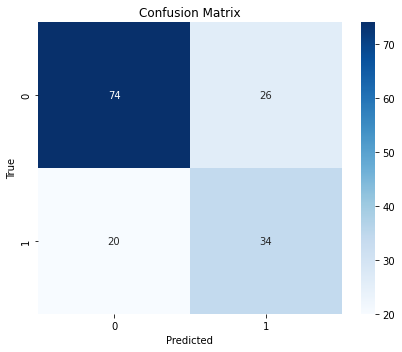

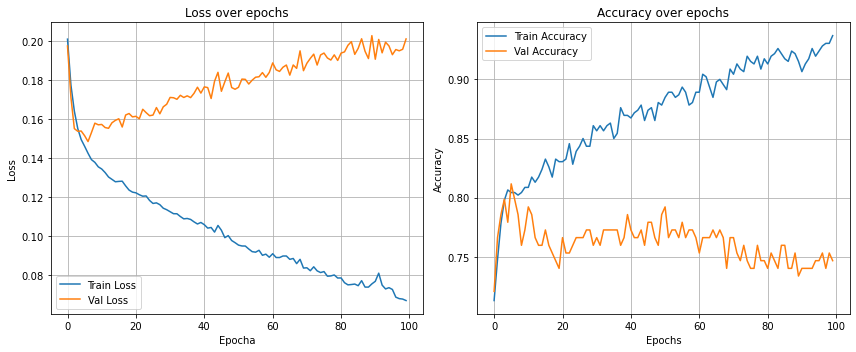

In [6]:
# Créer et entraîner le modèle
layer_sizes = [X_train.shape[1], 16,8, 1]
nn = NeuralNetwork(layer_sizes, learning_rate=0.01)

train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train, y_train, X_val, y_val, epochs=100, batch_size=64
)

# Prédictions et évaluation
y_pred = nn.predict(X_test)

print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

# Courbes de perte et d’accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Courbe de perte
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_title('Loss over epochs')
ax1.set_xlabel('Epocha')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Courbe d’accuracy
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Val Accuracy')
ax2.set_title('Accuracy over epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Epoch 0, Train Loss: 0.1743, Val Loss: 0.1661, Train Acc: 0.7413, Val Acc: 0.7338
Epoch 10, Train Loss: 0.1271, Val Loss: 0.1580, Train Acc: 0.8304, Val Acc: 0.7597
Epoch 20, Train Loss: 0.1025, Val Loss: 0.1700, Train Acc: 0.8696, Val Acc: 0.7792
Epoch 30, Train Loss: 0.0802, Val Loss: 0.2006, Train Acc: 0.9130, Val Acc: 0.7338
Epoch 40, Train Loss: 0.0542, Val Loss: 0.2040, Train Acc: 0.9457, Val Acc: 0.7532
Epoch 50, Train Loss: 0.0457, Val Loss: 0.2154, Train Acc: 0.9609, Val Acc: 0.7273
Epoch 60, Train Loss: 0.0398, Val Loss: 0.2201, Train Acc: 0.9587, Val Acc: 0.7273
Epoch 70, Train Loss: 0.0411, Val Loss: 0.2339, Train Acc: 0.9565, Val Acc: 0.7143
Epoch 80, Train Loss: 0.0404, Val Loss: 0.2205, Train Acc: 0.9587, Val Acc: 0.7078
Epoch 90, Train Loss: 0.0257, Val Loss: 0.2172, Train Acc: 0.9761, Val Acc: 0.7532

Rapport de classification (Test set) :
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       100
           1       0.5

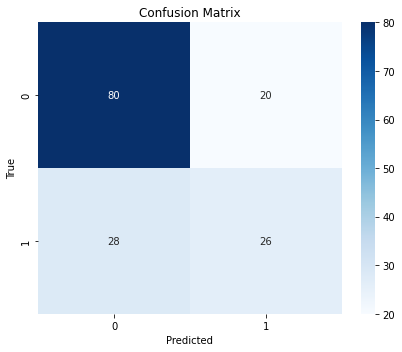

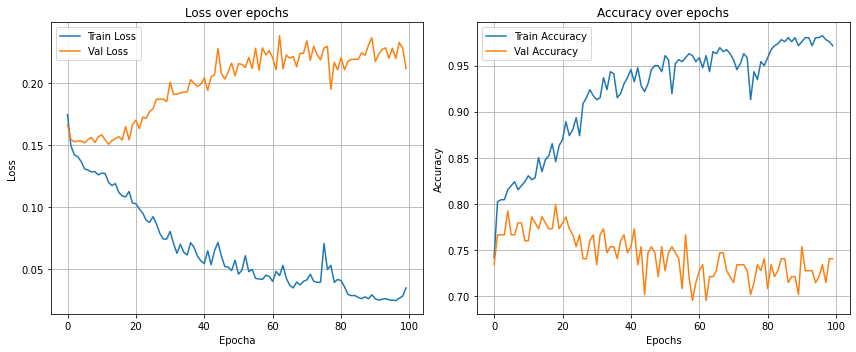

In [58]:
# Créer et entraîner le modèle
layer_sizes = [X_train.shape[1],32, 16,8, 1]
nn = NeuralNetwork(layer_sizes, learning_rate=0.01)

train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train, y_train, X_val, y_val, epochs=100, batch_size=32
)

# Prédictions et évaluation
y_pred = nn.predict(X_test)

print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

# Courbes de perte et d’accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Courbe de perte
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_title('Loss over epochs')
ax1.set_xlabel('Epocha')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Courbe d’accuracy
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Val Accuracy')
ax2.set_title('Accuracy over epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()